In [69]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
    assert int(torch.__version__.split(".")[0])>1 or (int(torch.__version__.split(".")[0])>2 and int(torch.__version__.split(".")[1]) >= 12), "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    # print(f"torch version: {torch.__version__}")
    # print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.0.post100
torchvision version: 0.15.2a0


In [70]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [71]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [72]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [73]:
import torchvision


effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()

# setup pretrained moddel instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# freeze base layers
for param in effnetb2.parameters():
    param.requires_grad = False
    

In [74]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output) 
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [75]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [76]:
set_seeds()

effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

In [77]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=3, bias=True)
)

In [78]:
# Print EffNetB2 model summary (uncomment for full output) 
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [79]:
# creating a function to make an EffNetB2 feature extractor

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    # 1,2,3 Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)
    
    # 4. freeze all the base layers
    for param in model.parameters():
        param.requires_grad = False
        
    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408,out_features=num_classes)
    )
    
    return model, transforms



In [80]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [81]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [82]:
# Print EffNetB2 model summary (uncomment for full output) 
summary(effnetb2, 
        input_size=(1, 3, 288, 288),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 288, 288]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 288, 288]     [1, 1408, 9, 9]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 288, 288]     [1, 32, 144, 144]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 288, 288]     [1, 32, 144, 144]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 144, 144]    [1, 32, 144, 144]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 144, 144]    [1, 32, 144, 144]    --                   --
│    └─Sequential (1)                                        [1, 32, 144, 144]    [1, 1

In [83]:
# Creating DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [84]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names

(<torch.utils.data.dataloader.DataLoader at 0x71737c194ed0>,
 ['pizza', 'steak', 'sushi'])

In [85]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [87]:
# Training EffNetB2 feature extractor
from going_modular.going_modular import engine

device = 'cuda'

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params = effnetb2.parameters(),
                             lr=1e-3)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/joseph/miniconda3/envs/multimodal/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1719512383855/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 1 | train_loss: 0.9855 | train_acc: 0.5604 | test_loss: 0.7407 | test_acc: 0.9347
Epoch: 2 | train_loss: 0.7175 | train_acc: 0.8438 | test_loss: 0.5869 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5876 | train_acc: 0.8917 | test_loss: 0.4909 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4474 | train_acc: 0.9062 | test_loss: 0.4355 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4290 | train_acc: 0.9104 | test_loss: 0.3915 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4380 | train_acc: 0.8896 | test_loss: 0.3512 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4245 | train_acc: 0.8771 | test_loss: 0.3268 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3897 | train_acc: 0.8958 | test_loss: 0.3457 | test_acc: 0.9290
Epoch: 9 | train_loss: 0.3749 | train_acc: 0.8812 | test_loss: 0.3129 | test_acc: 0.9131
Epoch: 10 | train_loss: 0.3757 | train_acc: 0.8604 | test_loss: 0.2813 | test_acc: 0.9688


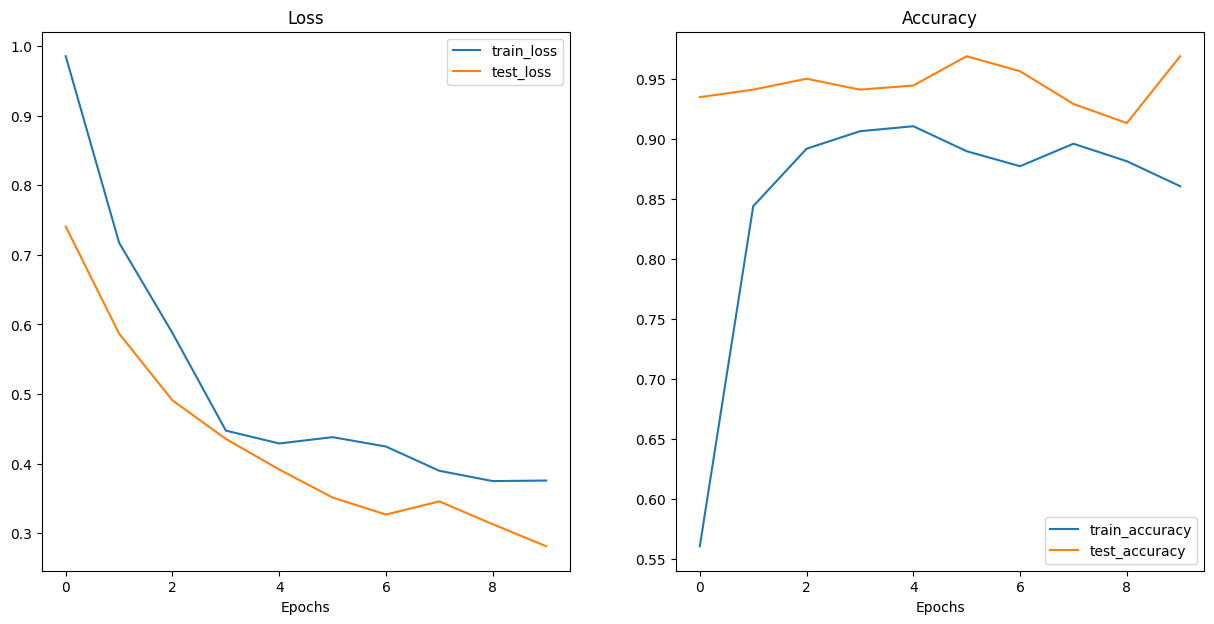

In [88]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [89]:
# Saving EffNetB2 feature extractor
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir = "models",
                 model_name="pretrained_effnetb2_feature_extractor.pth")

[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor.pth


In [91]:
# Size of model
from pathlib import Path

pretrained_effnetb2_model_size = Path("models/pretrained_effnetb2_feature_extractor.pth").stat().st_size / (1024*1024) # in MB

pretrained_effnetb2_model_size


29.84014320373535

In [92]:
# Collecting EffNetB2 feature extractor stats
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [95]:
effnetb2_results

{'train_loss': [0.9855283617973327,
  0.7174669941266377,
  0.5876179218292237,
  0.44742328027884165,
  0.4289502402146657,
  0.4380389531453451,
  0.42452231248219807,
  0.3896826446056366,
  0.374861478805542,
  0.37566561698913575],
 'train_acc': [0.5604166666666667,
  0.84375,
  0.8916666666666667,
  0.90625,
  0.9104166666666667,
  0.8895833333333333,
  0.8770833333333333,
  0.8958333333333334,
  0.88125,
  0.8604166666666667],
 'test_loss': [0.7407408475875854,
  0.5868981599807739,
  0.4908735930919647,
  0.4354967176914215,
  0.39154918789863585,
  0.35120723843574525,
  0.3267946124076843,
  0.3456908822059631,
  0.3129363775253296,
  0.28126387000083924],
 'test_acc': [0.934659090909091,
  0.940909090909091,
  0.95,
  0.940909090909091,
  0.9443181818181818,
  0.96875,
  0.95625,
  0.9289772727272727,
  0.9130681818181818,
  0.96875]}

In [97]:
# Create dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss":effnetb2_results["test_loss"][-1],
                  "test_acc":effnetb2_results["test_acc"][-1],
                  "number_of_parameters":effnetb2_total_params,
                  "model size (MB)":pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.28126387000083924,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model size (MB)': 29.84014320373535}

In [101]:
# Creating ViT feature extractor

# Check out ViT heads layer
vit = torchvision.models.vit_b_16()

vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [102]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    # Create ViT_B_16_pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)\
        
    # Freeze all the base layers
    for param in model.parameters():
        param.requires_grad=False
        
    # Change classifier head to suit our needs
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768,
                                          out_features=num_classes))
    
    return model, transforms

In [104]:
vit, vit_transforms = create_vit_model()

vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [105]:
vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [107]:
# Print ViT model summary (uncomment for full output) 
summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [108]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

len(train_dataloader_vit), len(test_dataloader_vit),class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [109]:
# Training ViT Extractor
from going_modular.going_modular import engine

device = 'cuda'

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                            epochs=10,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


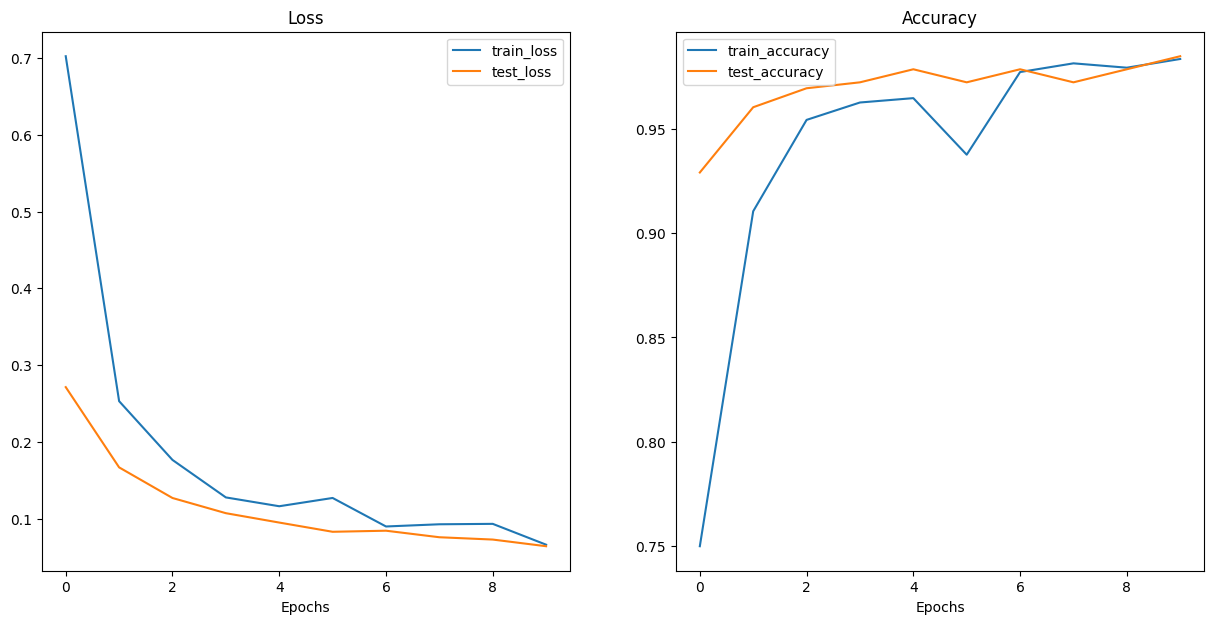

In [110]:
# Plot loss curves

from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [111]:
# Saving ViT feature extractor
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="pretrained_vit_model_size.pth")

[INFO] Saving model to: models/pretrained_vit_model_size.pth


In [112]:
# Checking size 

from pathlib import Path

pretrained_vit_model_size = Path("models/pretrained_vit_model_size.pth").stat().st_size / (1024*1024)

pretrained_vit_model_size

327.3649845123291

In [117]:
# Collecting ViT feature extractor stats

vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [124]:
# ViT statistics dictionary
vit_stats = {"test_loss":vit_results["test_loss"][-1],
                  "test_acc":vit_results["test_acc"][-1],
                  "number_of_parameters":vit_total_params,
                  "model size (MB)":pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06418211506679654,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model size (MB)': 327.3649845123291}

In [126]:
from pathlib import Path
# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2069289.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/48208.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1848936.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg')]

In [127]:
test_data_paths[0].parent.stem

'steak'

In [129]:
# Making predictions with trained models and timing
import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths:List[pathlib.Path],
                   model:torch.nn.Module,
                   transform:torchvision.transforms,
                   class_names:List[str],
                   device:str="cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    pred_list = []
    
    # Loop through target input paths
    for path in tqdm(paths):
        pred_dict = {}
        
        pred_dict["image_path"]=path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name # ground truth
        
        start_time = timer()
        img = Image.open(path)
        
        transformed_image = transform(img).unsqueeze(0).to(device)
        
        model = model.to(device)
        model.eval()
        
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU (python variables are on CPU)
            
            # Add pred prob + pred class to empty dictionary
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # End prediction timer
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)
            
        # check if predicted class matches ground truth class
        pred_dict["correct"] = class_name == pred_class
        
        # Append updated prediction dictionary
        pred_list.append(pred_dict)

    return pred_list
        


In [130]:
# EffNetB2 prediction
effnetb2_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")



  0%|          | 0/150 [00:00<?, ?it/s]

In [131]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1285886.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8901,
  'pred_class': 'steak',
  'time_for_pred': 0.099,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2069289.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.829,
  'pred_class': 'steak',
  'time_for_pred': 0.0332,
  'correct': True}]

In [132]:
# Turn test_pred_dicts into DataFrame # works on CPU
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.8901,steak,0.0990,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.8290,steak,0.0332,True
2,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.5062,steak,0.0310,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.8040,steak,0.0263,True
4,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9300,steak,0.0257,True
